<a href="https://colab.research.google.com/github/jungry/time_series/blob/main/TimeSeries_Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Week 11 - Assignment

## 1. Outlier Detection

### 1.1. Distribution-Based Methods

In [2]:
# Import the required modules: pandas, numpy, matplotlib
# Google Mount
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Create a new dataset using pH and Dissolved_Oxygen_mg_L
DWLR_data = pd.read_csv('/content/drive/Shared drives/timeseries-datasets/DWLR_Dataset.csv')
DWLR_data.head()

,Date,Water_Level_m,Temperature_C,Rainfall_mm,pH,Dissolved_Oxygen_mg_L
0,2023-01-01,2.124836,-0.601831,26.958453,6.948386,8.282231
1,2023-01-02,2.099955,0.396578,15.306932,6.952946,7.998230
2,2023-01-03,2.146121,0.139768,29.263846,6.912783,8.173989
3,2023-01-04,2.196756,0.327833,8.246142,6.972447,8.079537
4,2023-01-05,2.115765,-0.917756,35.654194,6.962424,8.425726


In [4]:
DWLR_data['Date'] = pd.to_datetime(DWLR_data['Date'])
ph_data = DWLR_data[['Date','pH']]
dissolved_oxygen_data = DWLR_data[['Date','Dissolved_Oxygen_mg_L']]

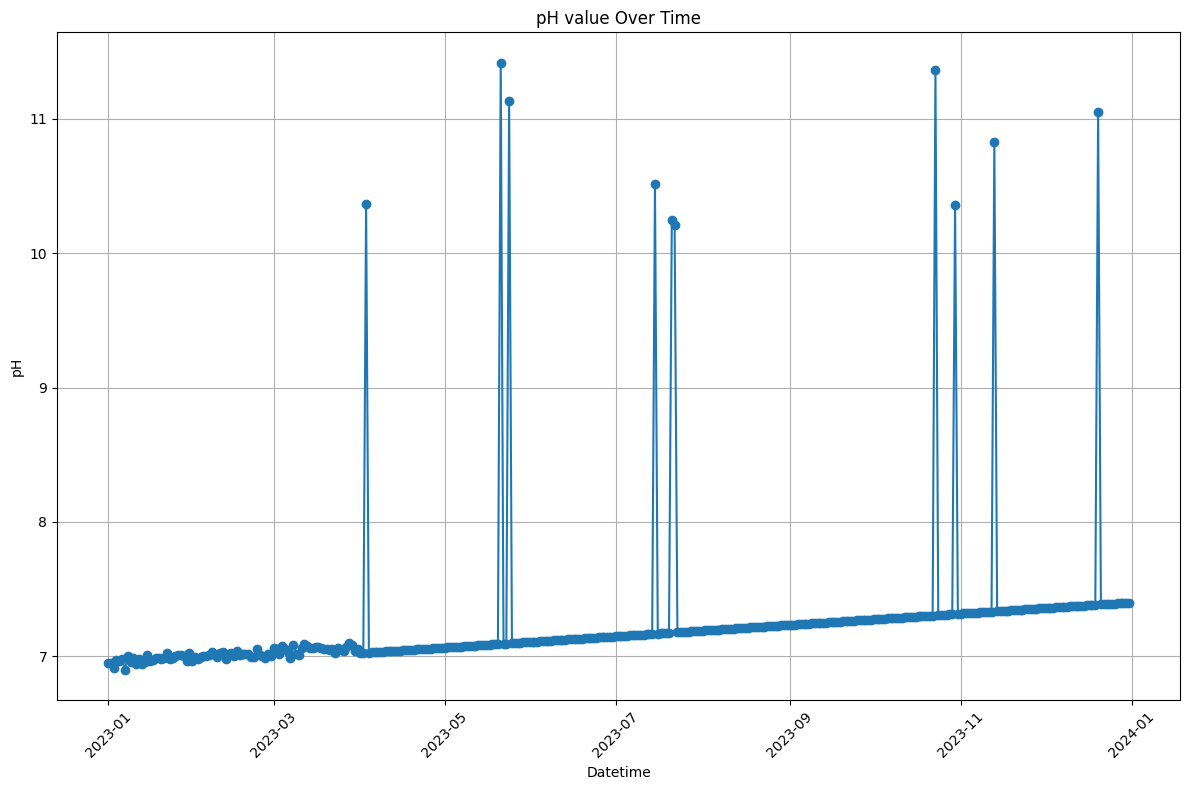

In [5]:
plt.figure(figsize=(12, 8))
plt.plot(ph_data['Date'], ph_data['pH'], marker='o', linestyle='-')
plt.title('pH value Over Time')
plt.xlabel('Datetime')
plt.ylabel('pH')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. Apply the Chauvenet criterion to detect water pH outliers in the time series data based on normal distribution assumptions. Plot the pH outliers with the original values.

In [6]:
# Define function which apply Chauvenet criterion to detect outlier
def chauvenet_criterion_ph(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    N = len(data)
    z_scores = np.abs(data - mean) / std_dev
    probabilities = 1 - stats.norm.cdf(z_scores)
    criterion_threshold = 1.0 / (2 * N)
    outliers = data[probabilities < criterion_threshold]
    return outliers

ph_outliers = chauvenet_criterion_ph(ph_data['pH'])

In [7]:
# Detect outlier with function
ph_data_values = ph_data['pH']
outliers = chauvenet_criterion_ph(ph_data_values)
outlier_indices = ph_data['pH'].isin(outliers)

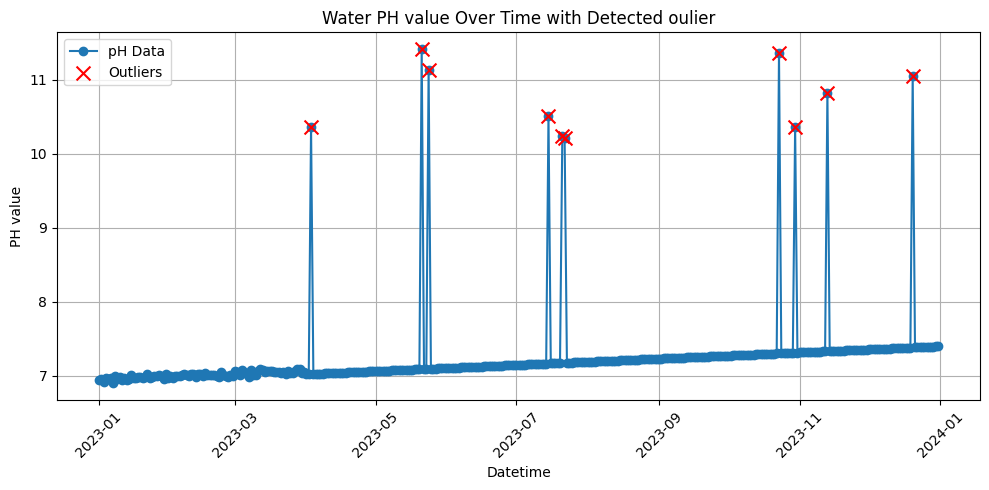

In [8]:
# Plot the pH outliers with the original values
plt.figure(figsize=(10, 5))
plt.plot(ph_data['Date'], ph_data['pH'], marker='o', linestyle='-', label='pH Data')
plt.scatter(ph_data['Date'][outlier_indices],
            ph_data['pH'][outlier_indices],
            color='red', marker='x', s=100, label='Outliers', zorder=5)
plt.title('Water PH value Over Time with Detected oulier')
plt.xlabel('Datetime')
plt.ylabel('PH value')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

2.  Winsorize the pH data by capping extreme values (e.g., 5th and 95th percentiles) and visualize the effect on the time series. Plot the effect of Winsorization on Time Series Data of pH values.

In [9]:
from scipy.stats.mstats import winsorize

In [10]:
ph_values = ph_data['pH'].values
winsorized_data = winsorize(ph_values, limits=[0.05, 0.05])
ph_data['winsorized_pH'] = winsorized_data

<ipython-input-10-f6e498890442>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ph_data['winsorized_pH'] = winsorized_data


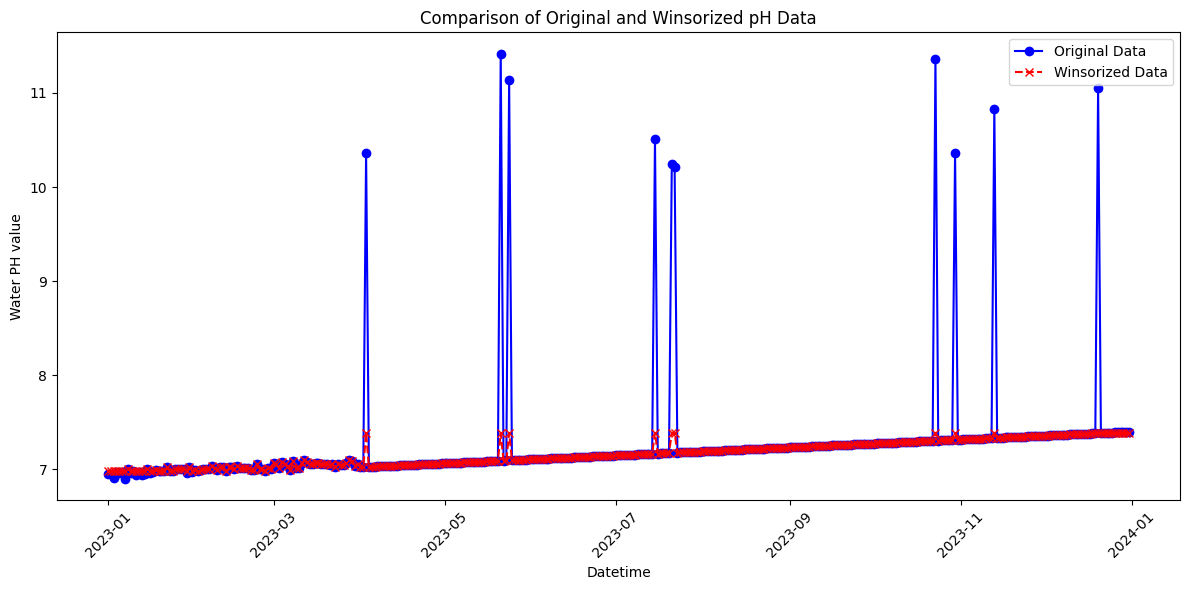

In [11]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
plt.plot(ph_data['Date'], ph_data['pH'], label='Original Data', color='b', linestyle='-', marker='o')
plt.plot(ph_data['Date'], ph_data['winsorized_pH'], label='Winsorized Data', color='r', linestyle='--', marker='x')
plt.title('Comparison of Original and Winsorized pH Data')
plt.xlabel('Datetime')
plt.ylabel('Water PH value')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### 1.2. Distance-Based Methods

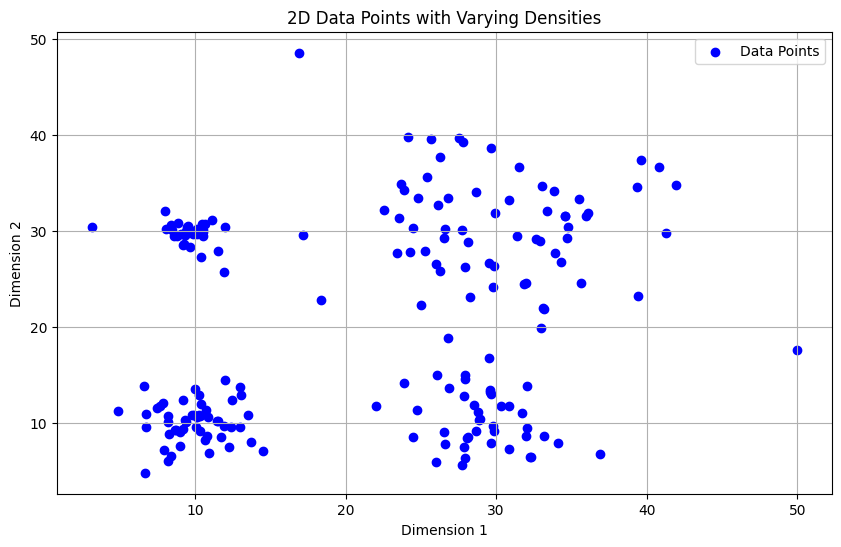

In [12]:
from sklearn.datasets import make_blobs

np.random.seed(0)

centers = [(10, 10), (30, 30), (10, 30), (30, 10)]
cluster_std = [2, 5, 1, 3]

X, _ = make_blobs(n_samples=[50, 60, 30, 40], centers=centers, cluster_std=cluster_std)

outliers = np.random.uniform(low=0, high=50, size=(10, 2))
data = np.vstack([X, outliers])

plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], color='blue', label='Data Points')
# plt.scatter(outliers[:, 0], outliers[:, 1], color='red', marker='x', s=100, label='Outliers')
plt.title('2D Data Points with Varying Densities')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

3. Define a function and detect outliers using the KNN algorithm. The parameters are free to set. Plot Outliers Detected by KNN Approach

In [13]:
# Define a function and detect outliers using the KNN algorithm. The parameters are free to set.
from sklearn.neighbors import NearestNeighbors

def detect_outliers_with_knn(data, n_neighbors=5, outlier_fraction=0.1):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(data)
    distances, indices = nbrs.kneighbors(data)
    mean_distance = distances[:, 1:].mean(axis=1)
    threshold = np.percentile(mean_distance, 100 * (1 - outlier_fraction))
    is_outlier = mean_distance > threshold
    outliers = data[is_outlier]
    return outliers, is_outlier, mean_distance, threshold

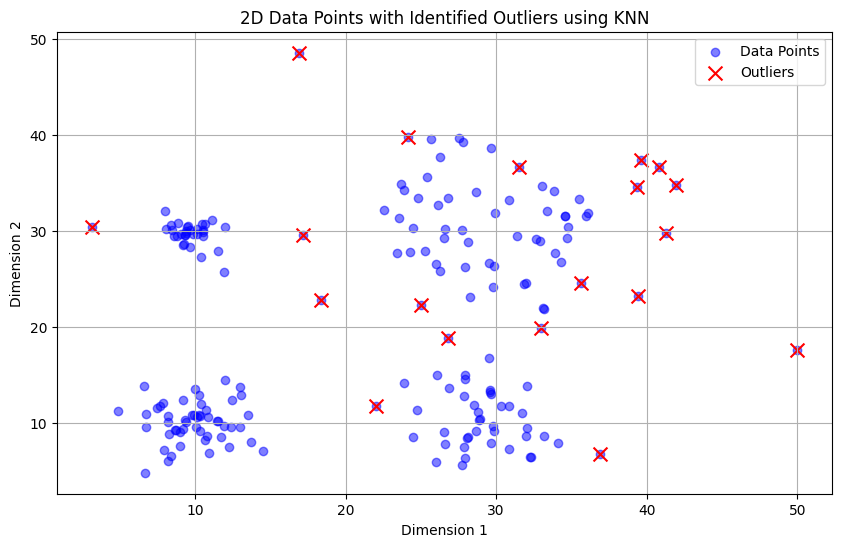

In [14]:
# Plot Outliers Detected by Distance-Based Approach
outliers_detected, is_outlier_mask, mean_distances, distance_threshold = detect_outliers_with_knn(
    data, n_neighbors=5, outlier_fraction=0.1
)

plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], color='blue', label='Data Points', alpha=0.5)
plt.scatter(
    outliers_detected[:, 0], outliers_detected[:, 1], color='red', marker='x', s=100, label='Outliers'
)
plt.title('2D Data Points with Identified Outliers using KNN')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

4. Apply the LOF algorithm from sklearn to detect outliers for upper data. The parameters are free to set. Plot Outliers Detected by Local Outlier Factor (LOF).

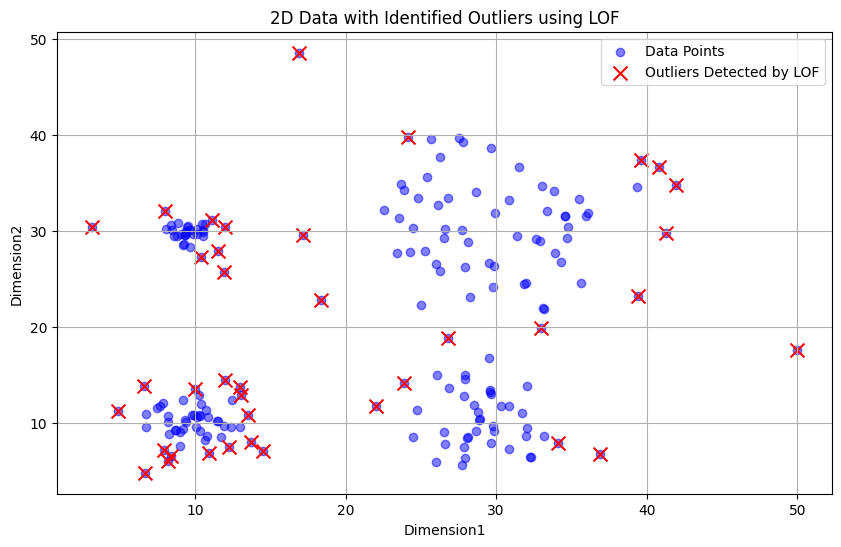

In [15]:
# Apply the LOF algorithm from sklearn to detect outliers for upper data. The parameters are free to set.
# Plot Outliers Detected by Local Outlier Factor (LOF)
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.2)
is_outlier = lof.fit_predict(data) == -1
outliers_detected = data[is_outlier]

plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], color='blue', label='Data Points', alpha=0.5)
plt.scatter(
    outliers_detected[:, 0], outliers_detected[:, 1], color='red', marker='x', s=100, label='Outliers Detected by LOF'
)
plt.title('2D Data with Identified Outliers using LOF')
plt.xlabel('Dimension1')
plt.ylabel('Dimension2')
plt.legend()
plt.grid(True)
plt.show()


## 2. Imputation of Missing Values

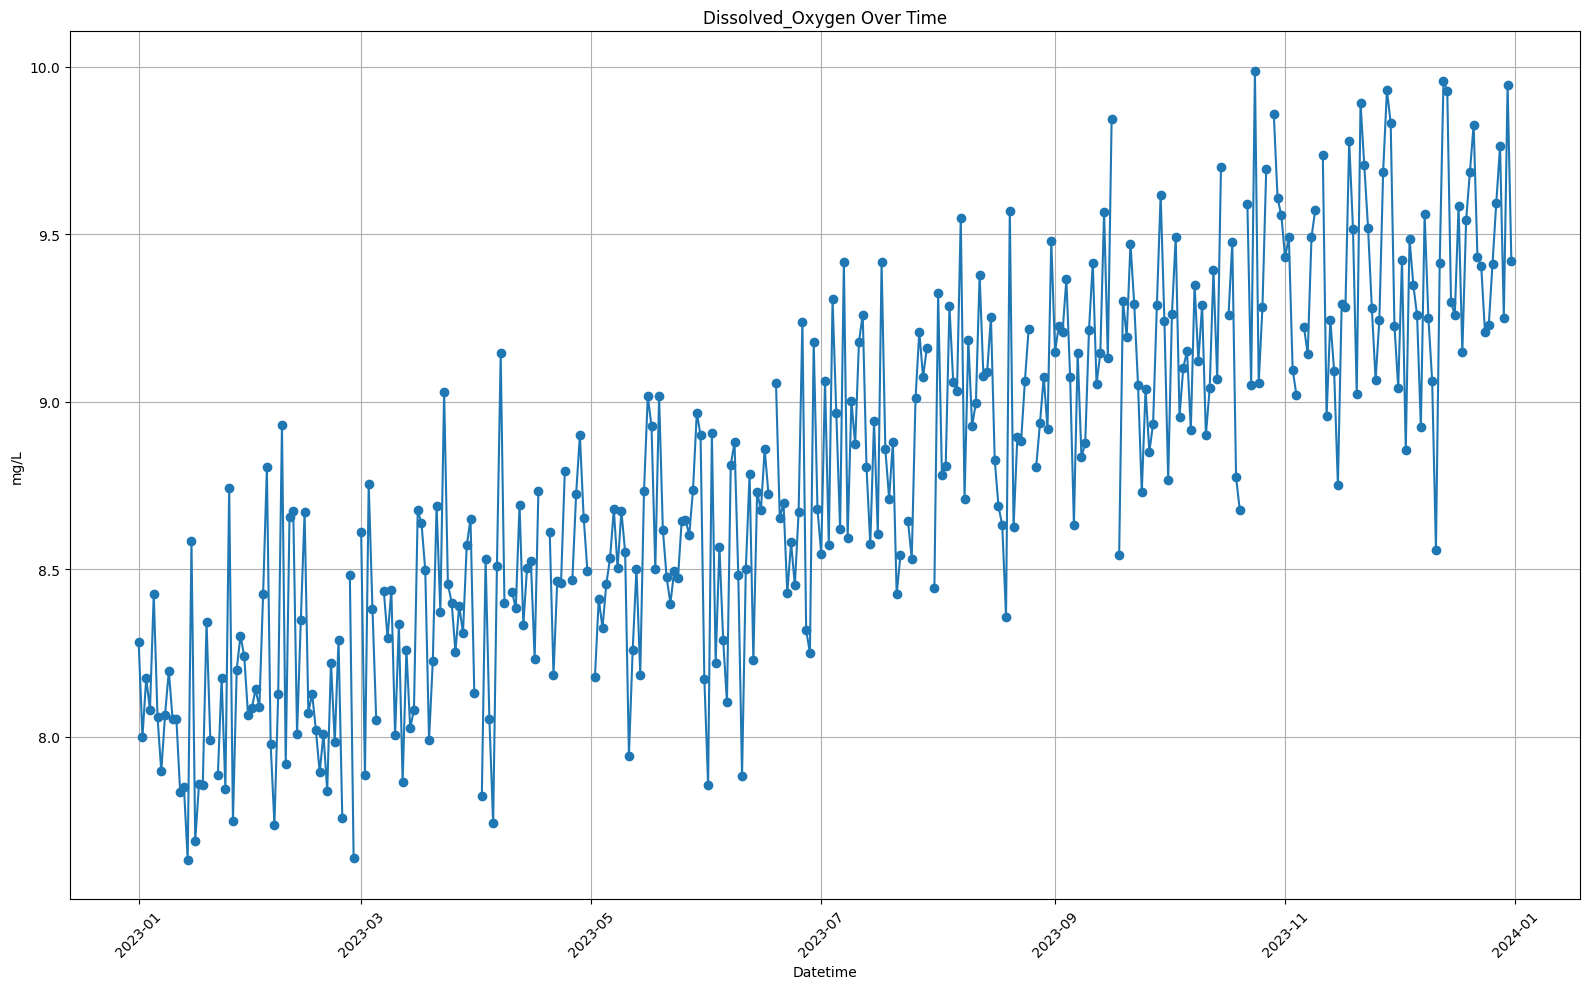

In [16]:
plt.figure(figsize=(16, 10))
plt.plot(dissolved_oxygen_data['Date'], dissolved_oxygen_data['Dissolved_Oxygen_mg_L'], marker='o', linestyle='-')
plt.title('Dissolved_Oxygen Over Time')
plt.xlabel('Datetime')
plt.ylabel('mg/L')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

5. Replace missing values with the mean, mode, and median of the values. Then visualize the dataframe which have missing values and imputed values.

In [17]:
# Replace missing values with the mean, mode, and median of the values.


dissolved_oxygen_data['mean_imputed'] = dissolved_oxygen_data['Dissolved_Oxygen_mg_L'].fillna(dissolved_oxygen_data['Dissolved_Oxygen_mg_L'].mean())


mode_value = dissolved_oxygen_data['Dissolved_Oxygen_mg_L'].mode()[0]

dissolved_oxygen_data['mode_imputed'] = dissolved_oxygen_data['Dissolved_Oxygen_mg_L'].fillna(mode_value)


dissolved_oxygen_data['median_imputed'] = dissolved_oxygen_data['Dissolved_Oxygen_mg_L'].fillna(dissolved_oxygen_data['Dissolved_Oxygen_mg_L'].median())

<ipython-input-17-b0950272e9d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dissolved_oxygen_data['mean_imputed'] = dissolved_oxygen_data['Dissolved_Oxygen_mg_L'].fillna(dissolved_oxygen_data['Dissolved_Oxygen_mg_L'].mean())
<ipython-input-17-b0950272e9d4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dissolved_oxygen_data['mode_imputed'] = dissolved_oxygen_data['Dissolved_Oxygen_mg_L'].fillna(mode_value)
<ipython-input-17-b0950272e9d4>:12: SettingWithCopyWarning: 
A value is trying to be set on a c

In [18]:
# Visualize the dataframe which have missing values and imputed values

nan_rows = dissolved_oxygen_data[dissolved_oxygen_data['Dissolved_Oxygen_mg_L'].isnull()]

nan_rows

,Date,Dissolved_Oxygen_mg_L,mean_imputed,mode_imputed,median_imputed
20,2023-01-21,NaN,8.778698,7.63279,8.750479
55,2023-02-25,NaN,8.778698,7.63279,8.750479
58,2023-02-28,NaN,8.778698,7.63279,8.750479
64,2023-03-06,NaN,8.778698,7.63279,8.750479
90,2023-04-01,NaN,8.778698,7.63279,8.750479
98,2023-04-09,NaN,8.778698,7.63279,8.750479
107,2023-04-18,NaN,8.778698,7.63279,8.750479
108,2023-04-19,NaN,8.778698,7.63279,8.750479
114,2023-04-25,NaN,8.778698,7.63279,8.750479
120,2023-05-01,NaN,8.778698,7.63279,8.750479
